calcaulate analytic thresholds of code capacity models for depolarizing channel for steane, shor, 5-qubit, and surface codes

In [43]:
from cs_entropy import *
from color_compass import *
from code_definitions import *
from lattice_definitions import *

from tqdm import tqdm

# autoreload 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
steane_code = SteaneCode()
print('Steane code')
print(steane_code.tableau)
five_code = FiveQubitCode()
print('Five qubit code')
print(five_code.tableau)
surface_code = SurfaceCode(3, 3)
print('Surface code')
print(surface_code.tableau)
shor_red_code = ShorRedCode(3, 3)
print('Shor red code')
print(shor_red_code.tableau)
shor_blue_code = ShorBlueCode(3, 3)
print('Shor blue code')
print(shor_blue_code.tableau)

Steane code
+-xz-xz-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++ ++ ++
| XZ __ __ _X X_ __ _Z
| _Z __ ZX Z_ __ _Z __
| _Z __ _X ZX __ _Z _Z
| _Z ZX __ __ _Z __ __
| _Z _X __ _X XZ X_ _Z
| XZ _X _X __ _Z _Z X_
| XZ _X _X _X _Z XZ XZ
Five qubit code
+-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++
| XZ XX __ XX _Z
| XZ _Z XX __ XX
| XZ XZ XZ _X X_
| XZ XX _Z _Z XX
| XZ X_ _X XZ XZ
Surface code
+-xz-xz-xz-xz-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++ ++ ++ ++ ++
| _Z _X __ __ __ X_ __ XZ __
| __ __ _X __ __ XZ __ _Z __
| __ Z_ ZX Z_ Z_ _Z __ __ __
| _Z ZX __ _X __ __ __ _Z __
| __ Z_ _X ZX __ __ _Z _Z __
| __ __ _X __ ZX __ _Z __ __
| XZ __ __ _X __ X_ __ X_ _Z
| X_ __ __ _X __ X_ _Z X_ XZ
| X_ __ __ __ _X X_ XZ X_ X_
Shor red code
+-xz-xz-xz-xz-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++ ++ ++ ++ ++
| _Z _X __ XZ __ __ __ __ __
| __ ZX Z_ _Z _Z __ __ __ __
| __ _X __ __ XZ __ __ __ __
| _Z _X ZX __ __ _Z __ __ __
| __ _X _X __ __ XZ __ _Z __
| __ _X _X __ __ X_ __ XZ __
| XZ __ _X X_ __ __ _Z __ __
| X_ __ _X X_ __ __ XZ __ _Z
| X_ _

The threshold can be determined by the joint distribution of syndromes and logical effects as follows: 

Given $P(Z, Y)$, for each $y \in Y$, find the class $z(y)$ that has the highest probability. The optimal $z^*(y)$ which is the optimal correction. Remove that row from the joint distribution, then find all other instances of the syndrome, add their weight to the logical error, and remove them. 

In [101]:
def same_keys(key1, key2):
    return np.all(key1[0] == key2[0]) and np.all(key1[1] == key2[1])

def compute_mle_error_rate(joint_dist):
    new_joint_dist = joint_dist.copy()
    logical_error_rate = 0
    success_dist = {}
    failure_dist = {}
    while(len(new_joint_dist) > 0):
        # pick an element in the joint dist dictionary 
        key_og = next(iter(new_joint_dist))

        # get the syndrome 
        syndrome = key_og[0]


        # now, iterate over all the elements in the dictionary, 
        # and find the one that has the highest probability
        # record all the keys while doing this
        all_keys_with_same_syndrome = [key_og]
        val_max = new_joint_dist[key_og]
        key_max = key_og
        for key, value in new_joint_dist.items():
            if np.all(key[0] == syndrome):
                if not same_keys(key, key_og):
                    all_keys_with_same_syndrome.append(key)
                    if value > val_max:
                        val_max = value
                        key_max = key
        # now, we have the key with the highest probability
        # we can now compute the logical error rate
        # remove the highest weight key from the joint dist and add it to the success dist
        new_joint_dist.pop(key_max)
        success_dist[key_max] = val_max
        # also, remove it from the all_keys_with_same_syndrome list
        all_keys_with_same_syndrome.remove(key_max)

        # now, calculate the failure dist for all the other keys
        for key in all_keys_with_same_syndrome:
            failure_dist[key] = new_joint_dist[key]
            new_joint_dist.pop(key)
            logical_error_rate += failure_dist[key]
    return logical_error_rate, success_dist, failure_dist


# threshold of 5 qubit code

In [137]:
p_line = np.linspace(0, 0.2, 10)
depol_channels = [DepolarizingChannel(p, 5) for p in p_line]
joint_dists = [five_code.make_joint_distribution(depol_channel) for depol_channel in tqdm(depol_channels)]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 19.61it/s]


In [138]:
logical_error_rates = []
for joint_dist in joint_dists:
    logical_error_rate, success_dist, failure_dist = compute_mle_error_rate(joint_dist)
    logical_error_rates.append(logical_error_rate)

In [139]:
len(success_dist)

16

Text(0.5, 0, 'Depolarizing probability')

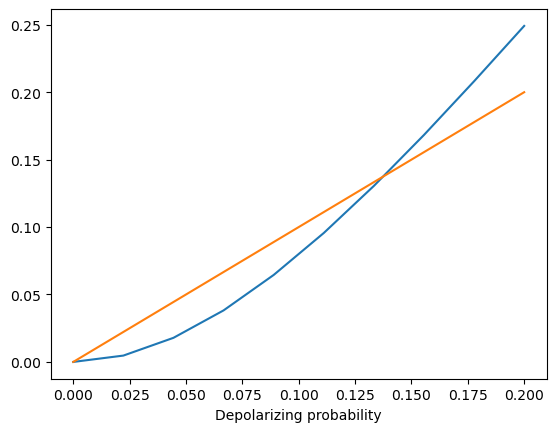

In [140]:
# plot the logical error rates and y = x
plt.plot(p_line, logical_error_rates, label='Logical error rate')
plt.plot(p_line, p_line, label='y=x')
plt.xlabel('Depolarizing probability')

In [143]:
# find the point at each the logical error rate is equal to the depolarizing probability
# fit to a spline before
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(p_line, logical_error_rates - p_line, s=0)
spline.set_smoothing_factor(0.01)
p_cross = spline.roots()
print(p_cross)

[0.1376109]


https://quantumcomputing.stackexchange.com/questions/36965/how-to-calculate-pseudo-threshold-of-the-5-1-3-code-analytically-to-match-si

# threshold of the steane code

In [127]:
p_line = np.linspace(0, 0.2, 10)
depol_channels = [DepolarizingChannel(p, 7) for p in p_line]
joint_dists = [steane_code.make_joint_distribution(depol_channel) for depol_channel in tqdm(depol_channels)]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


In [128]:
logical_error_rates = []
for joint_dist in joint_dists:
    logical_error_rate, success_dist, failure_dist = compute_mle_error_rate(joint_dist)
    logical_error_rates.append(logical_error_rate)

In [129]:
2**6

64

In [130]:
len(success_dist)

64

In [132]:
success_dist

{((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0)): 0.20993053497942346,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (0.0, 1.0)): 0.018062046639231777,
 ((1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (1.0, 1.0)): 0.018062046639231777,
 ((1.0, 1.0, 1.0, 0.0, 0.0, 0.0), (1.0, 0.0)): 0.018062046639231777,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 0.0), (0.0, 1.0)): 0.018062046639231777,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 1.0), (0.0, 1.0)): 0.018062046639231794,
 ((1.0, 1.0, 1.0, 0.0, 0.0, 1.0), (1.0, 1.0)): 0.002061320896204846,
 ((1.0, 1.0, 1.0, 1.0, 1.0, 0.0), (0.0, 1.0)): 0.002061320896204847,
 ((1.0, 1.0, 0.0, 1.0, 1.0, 0.0), (1.0, 1.0)): 0.018062046639231777,
 ((1.0, 1.0, 0.0, 0.0, 0.0, 1.0), (0.0, 1.0)): 0.0020613208962048466,
 ((0.0, 0.0, 1.0, 0.0, 0.0, 1.0), (1.0, 1.0)): 0.01806204663923181,
 ((0.0, 0.0, 1.0, 1.0, 1.0, 0.0), (1.0, 0.0)): 0.002061320896204847,
 ((1.0, 1.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0)): 0.018062046639231777,
 ((1.0, 1.0, 0.0, 1.0, 1.0, 1.0), (0.0, 1.0)): 0.002061320896204847,
 ((0.0, 0.0, 1.0, 1.0, 1.0, 1.0), (

In [133]:
failure_dist

{((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 1.0)): 0.0008850260631001377,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 1.0)): 0.0008850260631001377,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0)): 0.0008850260631001377,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (0.0, 0.0)): 0.004491810882487416,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (1.0, 0.0)): 0.0005422646547782354,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 1.0), (1.0, 1.0)): 0.0005422646547782354,
 ((1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (1.0, 0.0)): 0.0005422646547782355,
 ((1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (0.0, 0.0)): 0.00449181088248742,
 ((1.0, 1.0, 1.0, 1.0, 1.0, 1.0), (0.0, 1.0)): 0.0005422646547782354,
 ((1.0, 1.0, 1.0, 0.0, 0.0, 0.0), (1.0, 1.0)): 0.0005422646547782354,
 ((1.0, 1.0, 1.0, 0.0, 0.0, 0.0), (0.0, 1.0)): 0.0005422646547782353,
 ((1.0, 1.0, 1.0, 0.0, 0.0, 0.0), (0.0, 0.0)): 0.004491810882487422,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 0.0), (0.0, 0.0)): 0.004491810882487417,
 ((0.0, 0.0, 0.0, 1.0, 1.0, 0.0), (1.0, 0.0)): 0.0005422646547782354,
 ((0.0, 0.0, 0.0, 1.0, 1.

Text(0.5, 0, 'Depolarizing probability')

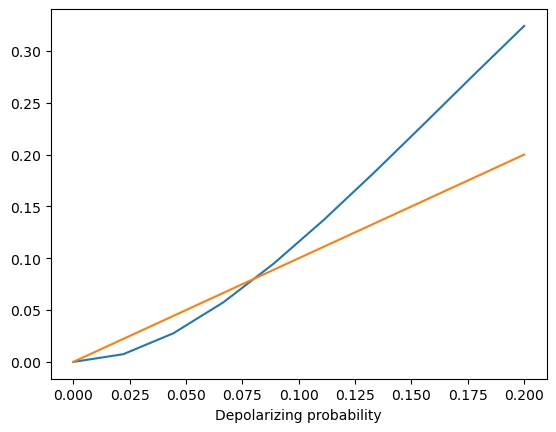

In [131]:
# plot the logical error rates and y = x
plt.plot(p_line, logical_error_rates, label='Logical error rate')
plt.plot(p_line, p_line, label='y=x')
plt.xlabel('Depolarizing probability')

In [3]:
2**(-1.5)

0.3535533905932738

# threshold of the surface code

In [134]:
p_line = np.linspace(0, 0.2, 10)
depol_channels = [DepolarizingChannel(p, 9) for p in p_line]
joint_dists = [surface_code.make_joint_distribution(depol_channel) for depol_channel in tqdm(depol_channels)]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:40<00:00, 16.07s/it]


In [135]:
logical_error_rates = []
for joint_dist in joint_dists:
    logical_error_rate, success_dist, failure_dist = compute_mle_error_rate(joint_dist)
    logical_error_rates.append(logical_error_rate)

Text(0.5, 0, 'Depolarizing probability')

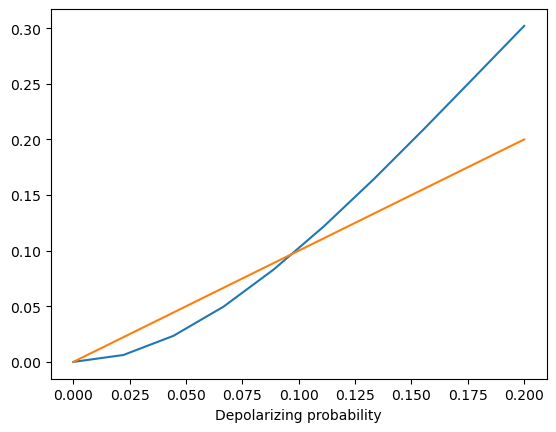

In [136]:
# plot the logical error rates and y = x
plt.plot(p_line, logical_error_rates, label='Logical error rate')
plt.plot(p_line, p_line, label='y=x')
plt.xlabel('Depolarizing probability')